In [550]:
import pandas as pd
import numpy as np

## Load Data

In [551]:
df_raw = pd.read_csv('Data/export.csv')

In [552]:
df = df_raw.copy()

In [553]:
display(df.head(3), df.shape)

,Patient ID,Age recode with <1 year olds,Marital status at diagnosis,Year of diagnosis,Sex,"Race recode (W, B, AI, API)","Derived AJCC T, 6th ed (2004-2015)","Derived AJCC N, 6th ed (2004-2015)","Derived AJCC M, 6th ed (2004-2015)","Derived AJCC Stage Group, 6th ed (2004-2015)",...,Derived EOD 2018 T (2018+),Derived EOD 2018 N (2018+),Derived EOD 2018 M (2018+),Derived EOD 2018 Stage Group (2018+),"Chemotherapy recode (yes, no/unk)",Radiation recode,RX Summ--Scope Reg LN Sur (2003+),CS tumor size (2004-2015),Tumor Size Summary (2016+),Survival months
0,840290,70-74 years,Married (including common law),2004,Female,White,T2,N0,M1,IV,...,Blank(s),Blank(s),Blank(s),Blank(s),Yes,None/Unknown,NaN,025,Blank(s),0008
1,960311,65-69 years,Separated,2004,Male,White,T3a,N1,M0,IV,...,Blank(s),Blank(s),Blank(s),Blank(s),Yes,None/Unknown,NaN,999,Blank(s),0053
2,9035323,55-59 years,Single (never married),2004,Female,Asian or Pacific Islander,T4,N3,M1,IV,...,Blank(s),Blank(s),Blank(s),Blank(s),No/Unknown,None/Unknown,NaN,999,Blank(s),0006


(1619, 28)

<Axes: xlabel='Year of diagnosis'>

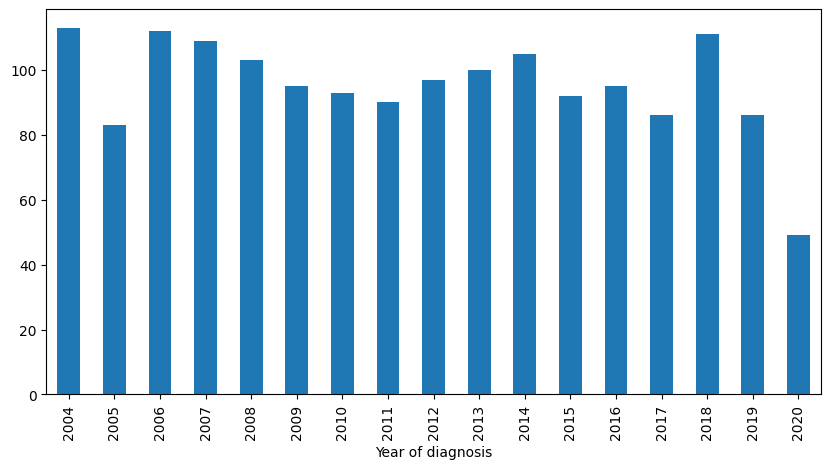

In [554]:
df['Year of diagnosis'].value_counts(dropna=False).sort_index().plot(kind='bar', figsize=(10, 5))

In [555]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 28 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Patient ID                                    1619 non-null   int64 
 1   Age recode with <1 year olds                  1619 non-null   object
 2   Marital status at diagnosis                   1619 non-null   object
 3   Year of diagnosis                             1619 non-null   int64 
 4   Sex                                           1619 non-null   object
 5   Race recode (W, B, AI, API)                   1619 non-null   object
 6   Derived AJCC T, 6th ed (2004-2015)            1604 non-null   object
 7   Derived AJCC N, 6th ed (2004-2015)            1604 non-null   object
 8   Derived AJCC M, 6th ed (2004-2015)            1604 non-null   object
 9   Derived AJCC Stage Group, 6th ed (2004-2015)  1604 non-null   object
 10  

## Data Cleaning

### Age
SEER database collection

In [556]:
df['Age recode with <1 year olds'].value_counts(dropna=False).sort_index()

Age recode with <1 year olds
25-29 years      2
30-34 years      1
35-39 years      5
40-44 years     15
45-49 years     49
50-54 years     88
55-59 years    155
60-64 years    213
65-69 years    297
70-74 years    287
75-79 years    235
80-84 years    174
85+ years       98
Name: count, dtype: int64

In [557]:
# Define a mapping function
def group_ages(age):
    if age in [ '35-39 years', '40-44 years', '45-49 years']:
        return '35-49 years'
    else:
        return age

In [558]:
# Apply the mapping function to the age column
df['Age recode with <1 year olds'] = df['Age recode with <1 year olds'].astype(str)
df['Age'] = df['Age recode with <1 year olds'].apply(group_ages)

# drop the original age column
df.drop('Age recode with <1 year olds', axis=1, inplace=True)

### Marital Status

In [559]:
def categorize_marital_status(df, column_name):
    # Define the mapping for each status to its group
    status_mapping = {
        'Married (including common law)': 'Married',
        'Unmarried or Domestic Partner': 'Married',  # Optional
        'Single (never married)': 'Single (never married)',
        'Separated': 'Single',  # Optional
        'Divorced': 'Single',   # Optional
        'Widowed': 'Single',    # Optional
        'Unknown': 'Unknown/Other'
    }

    # Apply the mapping to the specified column
    df['Marital Status'] = df[column_name].map(status_mapping).fillna('Unknown/Other')

    return df

# Apply the function to the 'Marital status at diagnosis' column
df = categorize_marital_status(df, 'Marital status at diagnosis')

# drop old column
df.drop(columns='Marital status at diagnosis', inplace=True)

### Sex

In [560]:
df['Sex'].value_counts(dropna=False)

Sex
Male      969
Female    650
Name: count, dtype: int64

In [561]:
# binary encoding
df['Sex_is_male'] = df['Sex'].map({'Male': 1, 'Female': 0})

# drop old column
df.drop('Sex', axis=1, inplace=True)

### Race

In [562]:
df['Race recode (W, B, AI, API)'].value_counts(dropna=False)

Race recode (W, B, AI, API)
White                            1388
Black                             164
Asian or Pacific Islander          55
American Indian/Alaska Native      12
Name: count, dtype: int64

In [563]:
# Group Asian or Pacific Islander and American Indian/Alaska Native as Other
df['Race']= df['Race recode (W, B, AI, API)'].replace({
    'Asian or Pacific Islander': 'Other', 
    'American Indian/Alaska Native': 'Other'})

# drop old column
df.drop('Race recode (W, B, AI, API)', axis=1, inplace=True)

In [564]:
df['Race'].value_counts(dropna=False)

Race
White    1388
Black     164
Other      67
Name: count, dtype: int64

### Chemotherapy recode (yes, no/unk)

In [565]:
# map Chemotherapy recode (yes, no/unk) into 1: Yes and 0:No/Unknown
df['Chemotherapy'] = df['Chemotherapy recode (yes, no/unk)'].map({'Yes': 1, 'No/Unknown': 0})

# drop original column
df.drop(columns=['Chemotherapy recode (yes, no/unk)'], inplace=True)

### Radiation

In [566]:
df['Radiation recode'].value_counts(dropna=False)

Radiation recode
None/Unknown                                             930
Beam radiation                                           620
Refused (1988+)                                           30
Recommended, unknown if administered                      21
Radiation, NOS  method or source not specified            13
Radioactive implants (includes brachytherapy) (1988+)      3
Combination of beam with implants or isotopes              2
Name: count, dtype: int64

In [567]:
def map_radiation_values(value):
    # Define the values to be mapped to 0
    values_for_zero = ['None/Unknown', 'Refused (1988+)',
                        'Recommended, unknown if administered']
    
    # Check if the value is in the list for 0, else return 1
    return 0 if value in values_for_zero else 1

# Apply the function to the 'Radiation Recode' column
df['Radiation recode'] = df['Radiation recode'].apply(map_radiation_values)

### RX Summ--Scope Reg LN Sur (2003+)

In [568]:
df['RX Summ--Scope Reg LN Sur (2003+)'].value_counts(dropna=False)

RX Summ--Scope Reg LN Sur (2003+)
NaN                                                           1135
4 or more regional lymph nodes removed                         210
Biopsy or aspiration of regional lymph node, NOS               157
1 to 3 regional lymph nodes removed                             73
Unknown or not applicable                                       29
Number of regional lymph nodes removed unknown                  14
Sentinel node biopsy and lym nd removed same/unstated time       1
Name: count, dtype: int64

In [569]:
# NaN and Unknown or not applicable will be 0, the rest will be 1
df['Surgery'] = np.where(df['RX Summ--Scope Reg LN Sur (2003+)'].isna() | 
                         (df['RX Summ--Scope Reg LN Sur (2003+)'] == 'Unknown or not applicable'), 0, 1)

# drop old column
df.drop(columns='RX Summ--Scope Reg LN Sur (2003+)', inplace=True)

df['Surgery'].value_counts(dropna=False)

Surgery
0    1164
1     455
Name: count, dtype: int64

### T, N, M Transformation

In [570]:
df.columns

Index(['Patient ID', 'Year of diagnosis', 'Derived AJCC T, 6th ed (2004-2015)',
       'Derived AJCC N, 6th ed (2004-2015)',
       'Derived AJCC M, 6th ed (2004-2015)',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC T, 7th ed (2010-2015)',
       'Derived AJCC N, 7th ed (2010-2015)',
       'Derived AJCC M, 7th ed (2010-2015)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'Derived SEER Combined T (2016-2017)',
       'Derived SEER Combined N (2016-2017)',
       'Derived SEER Combined M (2016-2017)',
       'Derived SEER Cmb Stg Grp (2016-2017)', 'Derived EOD 2018 T (2018+)',
       'Derived EOD 2018 N (2018+)', 'Derived EOD 2018 M (2018+)',
       'Derived EOD 2018 Stage Group (2018+)', 'Radiation recode',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Age', 'Marital Status', 'Sex_is_male', 'Race',
       'Chemotherapy', 'Surgery'],
      dtype='object')

In [571]:
# Logic to combine the columns
df['T'] = df['Derived AJCC T, 6th ed (2004-2015)']
df.loc[df['Year of diagnosis'].between(2010, 2015), 'T'] = df['Derived AJCC T, 7th ed (2010-2015)']
df.loc[df['Year of diagnosis'].between(2016, 2017), 'T'] = df['Derived SEER Combined T (2016-2017)']
df.loc[df['Year of diagnosis'] >= 2018, 'T'] = df['Derived EOD 2018 T (2018+)']

df['N'] = df['Derived AJCC N, 6th ed (2004-2015)']
df.loc[df['Year of diagnosis'].between(2010, 2015), 'N'] = df['Derived AJCC N, 7th ed (2010-2015)']
df.loc[df['Year of diagnosis'].between(2016, 2017), 'N'] = df['Derived SEER Combined N (2016-2017)']
df.loc[df['Year of diagnosis'] >= 2018, 'N'] = df['Derived EOD 2018 N (2018+)']

df['M'] = df['Derived AJCC M, 6th ed (2004-2015)']
df.loc[df['Year of diagnosis'].between(2010, 2015), 'M'] = df['Derived AJCC M, 7th ed (2010-2015)']
df.loc[df['Year of diagnosis'].between(2016, 2017), 'M'] = df['Derived SEER Combined M (2016-2017)']
df.loc[df['Year of diagnosis'] >= 2018, 'M'] = df['Derived EOD 2018 M (2018+)']

# Dropping old columns
columns_to_drop = [
    'Derived AJCC T, 6th ed (2004-2015)',
    'Derived AJCC N, 6th ed (2004-2015)',
    'Derived AJCC M, 6th ed (2004-2015)',
    'Derived AJCC T, 7th ed (2010-2015)',
    'Derived AJCC N, 7th ed (2010-2015)',
    'Derived AJCC M, 7th ed (2010-2015)',
    'Derived SEER Combined T (2016-2017)',
    'Derived SEER Combined N (2016-2017)',
    'Derived SEER Combined M (2016-2017)',
    'Derived EOD 2018 T (2018+)',
    'Derived EOD 2018 N (2018+)',
    'Derived EOD 2018 M (2018+)'
]

df.drop(columns=columns_to_drop, inplace=True)

df.columns

Index(['Patient ID', 'Year of diagnosis',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'Derived SEER Cmb Stg Grp (2016-2017)',
       'Derived EOD 2018 Stage Group (2018+)', 'Radiation recode',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Age', 'Marital Status', 'Sex_is_male', 'Race',
       'Chemotherapy', 'Surgery', 'T', 'N', 'M'],
      dtype='object')

In [572]:
df['T'].value_counts(dropna=False)

T
T4          403
T3          167
T2          161
TX          140
T2a         136
T1           94
88           76
T1b          56
T1a          43
T2b          41
T2NOS        29
c4           29
c3           27
cX           24
c2           16
NaN          15
T4a          13
T3b          12
T1c          12
c2A          12
T0           10
c2B          10
p2A          10
T3a           8
Blank(s)      7
p1B           6
T2c           5
p3            5
c1            5
c1A           5
T3NOS         5
p1A           5
c1B           4
T4b           4
c1C           3
T1mi          3
p3B           2
c3B           2
p4            2
p2B           2
p2C           1
T2a2          1
T2aNOS        1
Tis           1
T1NOS         1
p2            1
p4A           1
c0            1
p3A           1
T3c           1
Name: count, dtype: int64

In [573]:
df['N'].value_counts(dropna=False)

N
N2          526
N0          390
N3          188
N1          138
NX           97
88           76
c2           49
c0           48
c3           18
NaN          15
p0           14
cX           13
c1           13
p2            8
p1            8
Blank(s)      7
N2b           4
N2a           3
p3            2
N2c           1
p2B           1
Name: count, dtype: int64

In [574]:
df['M'].value_counts(dropna=False)

M
M0          602
M1          321
M1b         241
M1a          77
c0           76
88           76
M1c          68
c1B          38
MX           34
p1B          21
NaN          15
c1A          13
c1           12
p1            7
Blank(s)      7
M1NOS         4
c1C           3
p1A           3
p1C           1
Name: count, dtype: int64

In [575]:
def replace_first_char(row, column_name):
    # Check if the value is a string and starts with 'p' or 'c'
    if isinstance(row, str) and row[0] in ['p', 'c']:
        return column_name + row[1:]
    else:
        return row

# Applying the function to each column
df['T'] = df['T'].apply(lambda x: replace_first_char(x, 'T'))
df['N'] = df['N'].apply(lambda x: replace_first_char(x, 'N'))
df['M'] = df['M'].apply(lambda x: replace_first_char(x, 'M'))

In [576]:
# Dropping rows when T = '88', 'Blank(s)', 'Not applicable', 'TX', 'Tis'
df = df[~df['T'].isin(['88', 'Blank(s)', 'Not applicable', 'TX', 'Tis', 'T0'])].copy()

# Dropping rows when N = '88', 'Blank(s)', 'Not applicable', 'NX'
df = df[~df['N'].isin(['88', 'Blank(s)', 'Not applicable', 'NX'])].copy()

# Dropping rows when M = '88', 'Blank(s)', 'Not applicable'
df = df[~df['M'].isin(['88', 'Blank(s)', 'Not applicable','MX'])].copy()

In [577]:
def extract_main_category(value):
    if isinstance(value, str):
        # Find the first occurrence of a digit in the string
        for i, char in enumerate(value):
            if char.isdigit():
                # Return the string up to the second digit (inclusive)
                return value[:i+1]
    return value

# Apply the function to the 'T' column
df['T'] = df['T'].apply(extract_main_category)

# Display the updated DataFrame
print(df['T'].value_counts(dropna=False).sort_index())

T
T1     227
T2     409
T3     224
T4     415
NaN     15
Name: count, dtype: int64


In [578]:
# Apply the function to the 'N' column
df['N'] = df['N'].apply(extract_main_category)

# Display the updated DataFrame
print(df['N'].value_counts(dropna=False).sort_index())

N
N0     413
N1     144
N2     536
N3     182
NaN     15
Name: count, dtype: int64


In [579]:
# Apply the function to the 'M' column
df['M'] = df['M'].apply(extract_main_category)

# Display the updated DataFrame
print(df['M'].value_counts(dropna=False).sort_index())

M
M0     618
M1     657
NaN     15
Name: count, dtype: int64


In [580]:
# drop the NaN values in T or N or M
df = df.dropna(subset=['T', 'N', 'M'])

df['T'].value_counts(dropna=False)

T
T4    415
T2    409
T1    227
T3    224
Name: count, dtype: int64

### Group stage

In [581]:
df.columns  

Index(['Patient ID', 'Year of diagnosis',
       'Derived AJCC Stage Group, 6th ed (2004-2015)',
       'Derived AJCC Stage Group, 7th ed (2010-2015)',
       'Derived SEER Cmb Stg Grp (2016-2017)',
       'Derived EOD 2018 Stage Group (2018+)', 'Radiation recode',
       'CS tumor size (2004-2015)', 'Tumor Size Summary (2016+)',
       'Survival months', 'Age', 'Marital Status', 'Sex_is_male', 'Race',
       'Chemotherapy', 'Surgery', 'T', 'N', 'M'],
      dtype='object')

In [582]:
# Logic to combine the columns
df['SEER Combined/AJCC Cancer Stage Group'] = df['Derived AJCC Stage Group, 6th ed (2004-2015)']
df.loc[df['Year of diagnosis'].between(2010, 2015), 'SEER Combined/AJCC Cancer Stage Group'] = df['Derived AJCC Stage Group, 7th ed (2010-2015)']
df.loc[df['Year of diagnosis'].between(2016, 2017), 'SEER Combined/AJCC Cancer Stage Group'] = df['Derived SEER Cmb Stg Grp (2016-2017)']
df.loc[df['Year of diagnosis'] >= 2018, 'SEER Combined/AJCC Cancer Stage Group'] = df['Derived EOD 2018 Stage Group (2018+)']

# dropping old columns
columns_to_drop = [
    'Derived AJCC Stage Group, 6th ed (2004-2015)',
    'Derived AJCC Stage Group, 7th ed (2010-2015)',
    'Derived SEER Cmb Stg Grp (2016-2017)',
    'Derived EOD 2018 Stage Group (2018+)'
]

df.drop(columns=columns_to_drop, inplace=True)

In [583]:
df['SEER Combined/AJCC Cancer Stage Group'].value_counts(dropna=False).sort_index()

SEER Combined/AJCC Cancer Stage Group
1          4
1A        10
1A1        2
1A2        1
1A3        4
1B        11
2          9
2A         5
2B        12
3          2
3A        36
3B        17
3C         5
4         88
4A        33
4B        51
4C         1
I          5
IA        55
IB        58
II        18
IIA       36
IIB       35
III       17
IIIA     133
IIIB     114
IIIC       3
IIIC1      1
IV       495
IVA        6
IVB        7
IVC        1
Name: count, dtype: int64

In [584]:
def categorize_stage(df, column_name):
    # Define the mapping for each stage to its group
    stage_mapping = {
        '1':'I', '1A': 'I', '1A1': 'I', '1A2': 'I', '1A3': 'I', '1B': 'I', 'IA': 'I', 'IB': 'I', 'I': 'I',
        '2': 'II', '2A': 'II', '2B': 'II', 'II': 'II', 'IIA': 'II', 'IIB': 'II',
        '3':'III', '3A': 'III', '3B': 'III', '3C': 'III', 'IIIA': 'III', 'IIIB': 'III', 'IIIC':'III','IIIC1':'III', 'III': 'III', 'IIIC2':'III', 
        '4': 'IV', '4A': 'IV', '4B': 'IV', '4C':'IV','IV': 'IV', 'IVA':'IV', 'IVB':'IV', 'IVC':'IV'
    }

    # Apply the mapping to the specified column
    df['Grouped Stage'] = df[column_name].map(stage_mapping)

    return df


df = categorize_stage(df, 'SEER Combined/AJCC Cancer Stage Group')

df['Grouped Stage'].value_counts(dropna=False).sort_index()

Grouped Stage
I      150
II     115
III    328
IV     682
Name: count, dtype: int64

In [585]:
# drop old column
df.drop(columns='SEER Combined/AJCC Cancer Stage Group', inplace=True)

### Tumor size

In [586]:
# Logic to combine the columns
df['Tumor Size'] = df['CS tumor size (2004-2015)']
df.loc[df['Year of diagnosis'] >= 2016, 'Tumor Size'] = df['Tumor Size Summary (2016+)']


# drop old columns
columns_to_drop = [
    'CS tumor size (2004-2015)',
    'Tumor Size Summary (2016+)'
]

df.drop(columns=columns_to_drop, inplace=True)

In [587]:
df['Tumor Size'] = df['Tumor Size'].astype('int64')
df['Tumor Size'].value_counts(dropna=False).sort_index()

Tumor Size
1        1
2        1
5        1
6        2
7        2
      ... 
990      1
991      1
992      1
994      2
999    226
Name: count, Length: 133, dtype: int64

In [588]:
df[df['Tumor Size'] > 989]['Tumor Size'].value_counts(dropna=False).sort_index()

Tumor Size
990      1
991      1
992      1
994      2
999    226
Name: count, dtype: int64

In [589]:
# according to the dictionary, drop the tumor size that is larger than 989
df = df[df['Tumor Size'] <= 989].copy()

### Survival months

In [590]:
# drop the NaN values in Survival months
df = df.dropna(subset=['Survival months'])

# drop the 'Unknown' values in Survival months
df = df[df['Survival months'] != 'Unknown']

In [591]:
df['Survival months'] = df['Survival months'].astype('int64')

In [592]:
df.shape

(1044, 15)

<Axes: title={'center': 'Survival Months'}, xlabel='Survival Months', ylabel='Frequency'>

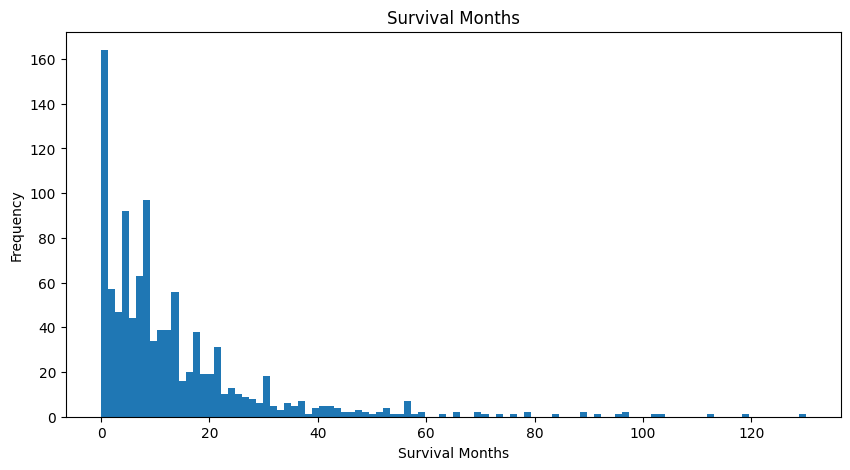

In [593]:
# plot the survival months
df['Survival months'].plot(kind='hist', bins=100,
                            figsize=(10, 5), title='Survival Months',
                            xlabel='Survival Months', ylabel='Frequency')

In [594]:
df['Survival months'].value_counts(dropna=False).sort_index()

Survival months
0      88
1      76
2      57
3      47
4      50
       ..
102     1
103     1
112     1
119     1
130     1
Name: count, Length: 79, dtype: int64

In [595]:
# save the df to a new csv file called cleaned_data.csv
df.to_csv('Data/cleaned_data.csv', index=False)